# Mekha's First Jupyter Notebook

#### 11/23/2020

#### Overview
This notebook will summarize the methods used to make 1 week, 2 week, and seasonal streamflow forecasts. It will step through the script to generate maps/graphs and to create the regression model for forecasting.

At the beginning of the semester, my 1 and 2 week forecasts were simply based on previous two weeks of flow. This method was more successful in the first few weeks of the semester because streamflow was very low and relatively stable. Once the trend in streamflow began increasing, this method consistenly underpredicted. I switch to an auto-regressive model based on three time lags once we learned how to build models in class. This method was more successful at capturing increasing trends in the data and predicting accordingly. After being exposed to other datasets and working on the group project, I furhter improved my linear regression model to incorporate other variables which impact flow; precipitation and temperature. The r<sup>2</sup> value of my model improved as a result, decreasing the error between observed and simulated values. The model still underpredicts high streamflow.

#### Import Modules
First, import all the modules and packages needed to run this script.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import datetime
import json
import urllib.request as req
import urllib
import dataretrieval.nwis as nwis
import geopandas as gpd
import fiona
from shapely.geometry import Point
import contextily as ctx

#### Mapping the Verde
Next, make a map to get us oriented and understand the study area. We are forecasting streamflow for a USGS gage located midway along the Verde River near Camp Verde, AZ. The following map will plot watershed boundaries, major rivers/streams, and USGS gage locations. The Verde River, Verde River Watershed, and Camp Verde gage of interest are highlighted. (Images is inserted here because this section of code cannot be run without the GIS files).

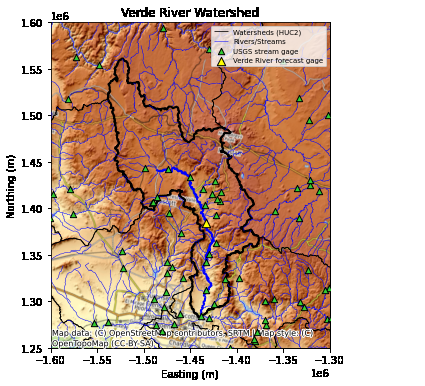

C:\Users\mpereira\Miniconda3\envs\hastools\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\mpereira\Miniconda3\envs\hastools\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
C:\Users\mpereira\Miniconda3\envs\hastools\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. 

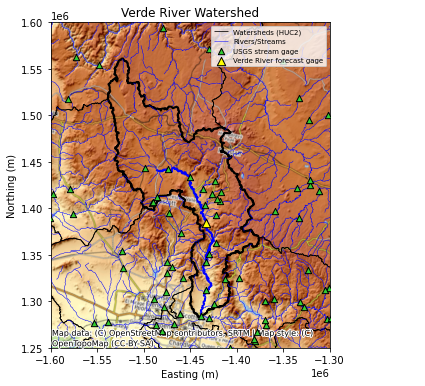

In [3]:
# Dataset 1: USGS stream gauges
# Download Gauges II USGS stream gauge dataset here:
# https://water.usgs.gov/GIS/metadata/usgswrd/XML/gagesII_Sept2011.xml#stdorder
# Read in using geopandas
file = os.path.join('../data/GIS_files', 'gagesII_9322_sept30_2011.shp')
gages = gpd.read_file(file)

# Filter to only AZ gauges
gages.columns
gages.STATE.unique()
gages_AZ = gages[gages['STATE'] == 'AZ']

# Dataset 2: Watershed boundaries for the Lower Colorado
# Download WBD_15_HU2_GDB.gdb from USGS here:
# https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products
# https://viewer.nationalmap.gov/basic/?basemap=b1&category=nhd&title=NHD%20View
# Read in using geopandas
file = os.path.join('../data/GIS_files', 'WBD_15_HU2_GDB.gdb')
fiona.listlayers(file)
HUC6 = gpd.read_file(file, layer="WBDHU6")

# Filter to only Verde River Watershed
HUC6.columns
HUC6.name.unique()
HUC6_Verde = HUC6[HUC6['name'] == 'Verde']

# Dataset 3: Major rivers/streams
# Download USA Rivers and Streams from Esri here:
# https://hub.arcgis.com/datasets/esri::usa-rivers-and-streams?geometry=-115.952%2C31.858%2C-109.014%2C33.476
# Read in using geopandas
file = os.path.join('../data/GIS_files', 'USA_Rivers_and_Streams.shp')
rivers_USA = gpd.read_file(file)

# Filter to only AZ
rivers_USA.columns
rivers_USA.State.unique()
rivers_AZ = rivers_USA[rivers_USA['State'] == 'AZ']

# Filter to only Verde
rivers_AZ.columns
rivers_AZ.Name.unique()
river_Verde = rivers_AZ[rivers_AZ['Name'] == 'Verde River']

# Dataset 4: Add point location of our stream gage
# https://waterdata.usgs.gov/nwis/inventory/?site_no=09506000&agency_cd=USGS
# Stream gauge:  34.44833333, -111.7891667
point_list = np.array([[-111.7891667, 34.44833333]])

# Make point into spatial feature
point_geom = [Point(xy) for xy in point_list]
point_geom

# Make a dataframe of the point
point_df = gpd.GeoDataFrame(point_geom, columns=['geometry'],
                            crs=HUC6.crs)

# Re-project datasets to match gages_AZ
points_project = point_df.to_crs(gages_AZ.crs)
HUC6_project = HUC6.to_crs(gages_AZ.crs)
HUC6_Verde_project = HUC6_Verde.to_crs(gages_AZ.crs)
rivers_AZ_project = rivers_AZ.to_crs(gages_AZ.crs)
river_Verde_project = river_Verde.to_crs(gages_AZ.crs)

# Plot projected datasets together
fig, ax = plt.subplots(figsize=(5, 7))

# Set map extent to zoom in on Verde River watershed
xlim = ([-1600000, -1300000])
ylim = ([1250000, 1600000])
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Draw layers in specified order using zorder
HUC6_project.boundary.plot(ax=ax, color=None, edgecolor='black', zorder=1,
                           label='Watersheds (HUC2)', linewidth=0.75)
HUC6_Verde_project.boundary.plot(ax=ax, color=None, edgecolor='black',
                                 linewidth=2, zorder=2)
rivers_AZ_project.plot(ax=ax, linewidth=0.5, color='b',
                       label='Rivers/Streams', zorder=3)
river_Verde_project.plot(ax=ax, linewidth=2, color='b', zorder=4)
gages_AZ.plot(ax=ax, markersize=40, marker='^', color='limegreen',
              edgecolor='black', label='USGS stream gage', zorder=5)
points_project.plot(ax=ax, color='yellow', marker='^', edgecolor='black',
                    markersize=70, label='Verde River forecast gage', zorder=6)

# Set map title and axes names
ax.set_title('Verde River Watershed')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.ticklabel_format(style="sci", scilimits=(0,0))
ax.legend(loc='upper right', fontsize=7)

# Add Topo basemap and reproject basemap to match gages_AZ
ctx.add_basemap(ax, crs=gages_AZ.crs, url=ctx.providers.OpenTopoMap)
plt.show()

#### Define Functions
Now onto the portion of the script that creates the forecasts. First, define any functions that will be used, so that it can be called later in the script. In this case, there is only one fuction which creates a 1 and 2 week forecast based on a linear regression model built later in the script.

In [4]:
def model_2wk_predict(precip1, precip2, temp1, temp2):

    """Function that makes 1 and 2 week flow predictions based on a regression
    model. The model should be built on 1 week time lagged flows, precip, and
    temperature, all weekly average variables. The model should be named
    'model'. The input variables are normalized, used to predict natural log
    of weekly average streamflow, which is converted back to raw streamflow
    values for the predictions. The two predictions are saved to an array and 
    printed.

    Inputs = (ints or floats) average weekly value for model variables:
           precip1 = expected average precip for next week in inches
           precip2 = expected average precip for two weeks from now in inches
           temp1 = expected average temp for next week in fahrenheit
           temp1 = expected average temp for two weeks from now in fahrenheit

    Output = (array) array containing two values which represent 1 and 2 week
    forecast based on the regression model
           model_predictions[0] = 1 week prediciton of average natural log flow
           model_predictions[1] = 2 week prediciton of average natural log flow
    """
    flow = data['flow_tm1_nm'].iloc[-1]
    precip1_nm = ((precip1 - data['precip'].mean()) / data['precip'].std())
    precip2_nm = ((precip1 - data['precip'].mean()) / data['precip'].std())
    temp1_nm = ((temp1 - data['airtemp'].mean()) / data['airtemp'].std())
    temp2_nm = ((temp1 - data['airtemp'].mean()) / data['airtemp'].std())

    model_predictions = np.zeros(2)
    for i in range(0, 2):
        log_flow = model.intercept_ \
                                   + model.coef_[0] * flow \
                                   + model.coef_[1] * precip1_nm\
                                   + model.coef_[2] * temp1_nm
        model_predictions[i] = np.exp(log_flow)
        print('Linear regression model ', i+1, ' week forecast is ',
              model_predictions[i].round(2), ' cfs')
        flow = ((log_flow - data['flow_log'].mean()) / data['flow_log'].std())
        precip1_nm = precip2_nm
        temp1_nm = temp2_nm

    return model_predictions

#### Import Data
For the 1 week and 2 week forecast, I use a linear regression built on lagged streamflow, precipitation, and temperature data. All data is imported as daily average data, which is converted to weekly average data. Streamflow data is imported from the USGS, and precipitation and temperature are imported from a mesowest station upstream of our forecast gage. All data is imported using API calls.

##### USGS streamflow data in cfs

In [5]:
# Read in USGS streamflow data and create dataframe of avg weekly flow
# Use nwis.get_record function to retrieve data

# Change stop_date each week
station_id = "09506000"
USGS_start = "2016-12-25"
USGS_stop = "2020-11-21"

data_flow = nwis.get_record(sites=station_id, service='dv',
                            start=USGS_start, end=USGS_stop,
                            parameterCd='00060')

# Rename columns
data_flow.columns = ['flow', 'code', 'site_no']

# Make index a recognized datetime format instead of string
data_flow.index = data_flow.index.strftime('%Y-%m-%d')

data_flow['datetime'] = pd.to_datetime(data_flow.index)

# Aggregate flow values to weekly
flow_weekly = data_flow.resample("W-SAT", on='datetime').mean()

print(flow_weekly)

                   flow
datetime               
2016-12-31  1013.571429
2017-01-07  2669.000000
2017-01-14   983.428571
2017-01-21  1088.142857
2017-01-28   826.571429
...                 ...
2020-10-24    80.157143
2020-10-31   108.971429
2020-11-07   126.571429
2020-11-14   154.714286
2020-11-21   156.714286

[204 rows x 1 columns]


##### Mesowest precipitation data in inches

In [6]:
# Read in Mesowest precip data using the API
# Change demotoken to your token when running
mytoken = 'ee2e11fb217d4d42b54782f4f101a397'

# This is the base url that will be the start final url
base_url = "http://api.mesowest.net/v2/stations/timeseries"

# Specific arguments for the data that we want
# Change end date each week
args = {
    'start': '201612250000',
    'end': '202011210000',
    'obtimezone': 'UTC',
    'vars': 'precip_accum_since_local_midnight',
    'stids': 'C4534',
    'units': 'precip|in',
    'token': mytoken}
apiString = urllib.parse.urlencode(args)

fullUrl = base_url + '?' + apiString

response = req.urlopen(fullUrl)
responseDict = json.loads(response.read())

# Pull out date and temperature data
dateTime = responseDict['STATION'][0]['OBSERVATIONS']['date_time']
precip = responseDict['STATION'][0]['OBSERVATIONS']['precip_accum_since_local_midnight_set_1']

# Create dataframe
data_precip = pd.DataFrame({'Precip': precip}, index=pd.to_datetime(dateTime))

# Aggregate to weekly
precip_weekly = data_precip.resample('W-SAT').mean()
precip_weekly['Precip'] = precip_weekly['Precip'].replace(np.nan, 0)

# Make index a datetime format consistent with flow data
precip_weekly.index = precip_weekly.index.strftime('%Y-%m-%d')

print(precip_weekly)

              Precip
2016-12-31  0.043673
2017-01-07  0.043709
2017-01-14  0.003000
2017-01-21  0.056871
2017-01-28  0.020779
...              ...
2020-10-24  0.000000
2020-10-31  0.000000
2020-11-07  0.001119
2020-11-14  0.009931
2020-11-21  0.000000

[204 rows x 1 columns]


##### Mesowest temperature data in fahrenheit

In [7]:
# Read in Mesowest precip data using the API
# Change demotoken to your token when running
mytoken = 'ee2e11fb217d4d42b54782f4f101a397'

# This is the base url that will be the start final url
base_url = "http://api.mesowest.net/v2/stations/timeseries"

# Specific arguments for the data that we want
# Change end date each week
args = {
    'start': '201612250000',
    'end': '202011210000',
    'obtimezone': 'UTC',
    'vars': 'air_temp',
    'stids': 'QVDA3',
    'units': 'temp|F',
    'token': mytoken}
apiString = urllib.parse.urlencode(args)

fullUrl = base_url + '?' + apiString

response = req.urlopen(fullUrl)
responseDict = json.loads(response.read())

# Pull out date and temperature data
dateTime = responseDict['STATION'][0]['OBSERVATIONS']['date_time']
airT = responseDict['STATION'][0]['OBSERVATIONS']['air_temp_set_1']

# Create dataframe
data_temp = pd.DataFrame({'AirTemp': airT}, index=pd.to_datetime(dateTime))

# Aggregate to weekly
temp_weekly = data_temp.resample('W-SAT').mean()

# Make index a datetime format consistent with flow data
temp_weekly.index = temp_weekly.index.strftime('%Y-%m-%d')

print(temp_weekly)

              AirTemp
2016-12-31  40.120180
2017-01-07  44.386845
2017-01-14  46.339048
2017-01-21  44.148452
2017-01-28  38.059583
...               ...
2020-10-24  65.529762
2020-10-31  54.934524
2020-11-07  64.392857
2020-11-14  45.166667
2020-11-21  54.230769

[204 rows x 1 columns]


#### Combine Datasets
Next combine all datasets into a single dataframe so that the linear regression model can easily be built off columns of data. Because all datasets have a datetime index in the same format, they are easily combined.

In [8]:
data = flow_weekly.copy()
data['precip'] = precip_weekly['Precip']
data['airtemp'] = temp_weekly['AirTemp']
print(data)

                   flow    precip    airtemp
datetime                                    
2016-12-31  1013.571429  0.043673  40.120180
2017-01-07  2669.000000  0.043709  44.386845
2017-01-14   983.428571  0.003000  46.339048
2017-01-21  1088.142857  0.056871  44.148452
2017-01-28   826.571429  0.020779  38.059583
...                 ...       ...        ...
2020-10-24    80.157143  0.000000  65.529762
2020-10-31   108.971429  0.000000  54.934524
2020-11-07   126.571429  0.001119  64.392857
2020-11-14   154.714286  0.009931  45.166667
2020-11-21   156.714286  0.000000  54.230769

[204 rows x 3 columns]


#### Setup Arrays Used to Build Linear Regression Model
The linear regression model will predict the natural log of average weekly streamflow (because the natural log transformation of streamflow follows a more normal distribution than the raw values of streamflow). The predictive input variables are natural log of weekly average streamflow lagged by 1 week, weekly average precipitation, and weekly average temperature. All input variables are normalized (subtract mean and divide by standard deviation) before being used to develop the regression. This prevents values with higher absolute values from dominating the regression. 

In [9]:
# We will predict natural log of flow
data['flow_log'] = np.log(data['flow'])

# Create column of normalized log flow for plotting
data['flow_log_nm'] = (data['flow_log'] - data['flow_log'].mean()) / data['flow_log'].std()

# Shift log flow to create column of 1 week lagged log flow
data['flow_tm1'] = data['flow_log'].shift(1)

# Remove first row of data since it is missing lagged flow
data = data.iloc[1:]

# 1st model input variable: normalized lagged log flow
data['flow_tm1_nm'] = (data['flow_tm1'] - data['flow_tm1'].mean()) / data['flow_tm1'].std()

# 2nd model input variable: normalized precip
data['precip_nm'] = (data['precip'] - data['precip'].mean()) / data['precip'].std()

# 3rd model input variable: normalized temp
data['airtemp_nm'] = (data['airtemp'] - data['airtemp'].mean()) / data['airtemp'].std()

print(data)

                   flow    precip    airtemp  flow_log  flow_log_nm  flow_tm1  \
datetime                                                                        
2017-01-07  2669.000000  0.043709  44.386845  7.889459     2.558484  6.921235   
2017-01-14   983.428571  0.003000  46.339048  6.891045     1.648384  7.889459   
2017-01-21  1088.142857  0.056871  44.148452  6.992228     1.740617  6.891045   
2017-01-28   826.571429  0.020779  38.059583  6.717286     1.489995  6.992228   
2017-02-04   842.857143  0.000000  44.357619  6.736797     1.507781  6.717286   
...                 ...       ...        ...       ...          ...       ...   
2020-10-24    80.157143  0.000000  65.529762  4.383989    -0.636910  4.299421   
2020-10-31   108.971429  0.000000  54.934524  4.691086    -0.356978  4.383989   
2020-11-07   126.571429  0.001119  64.392857  4.840807    -0.220500  4.691086   
2020-11-14   154.714286  0.009931  45.166667  5.041580    -0.037486  4.840807   
2020-11-21   156.714286  0.0

#### Create Linear Regression Model
Next create the linear regression model based on 2017-2018 data, and print out a summary of the model. Separating the dataset will allow the model to be trained on a portion of the data, and will reserve a portion of the data to review the model's prediction capability.

In [10]:
# For this model, training period = 2017-2018, testing = 2019-2020
train = data['2017-01-07':'2018-12-29'][['flow_log', 'flow_tm1_nm', 'precip_nm', 'airtemp_nm']]
test = data['2019-01-05':][['flow_log', 'flow_tm1_nm', 'precip_nm', 'airtemp_nm']]

# Fit linear regression model
model = LinearRegression()
x = train[['flow_tm1_nm', 'precip_nm', 'airtemp_nm']]
y = train['flow_log'].values
model.fit(x, y)
r_sq = np.round(model.score(x, y), 2)

print('coefficient of determination:', np.round(r_sq, 2))
print('intercept:', np.round(model.intercept_, 2))
print('slope:', np.round(model.coef_, 2))

coefficient of determination: 0.88
intercept: 5.07
slope: [ 0.92  0.14 -0.09]


#### Setup Prediction Functions
These functions will be used in plotting to visualize the model performance.

In [12]:
q_pred_train = model.predict(train[['flow_tm1_nm', 'precip_nm', 'airtemp_nm']])
q_pred_test = model.predict(test[['flow_tm1_nm', 'precip_nm', 'airtemp_nm']])

#### Generate Graphs
The following graphs help visualize the linear regression model data and performance. 

The first time series show the natural log of weekly average streamflow for the model period. The model is trained on data from 2017-2018. This date range was chosen because a longer range of years did not seem necessary with the goal being to predict weekly streamflow, not monthly or annual streamflow. With 2015-2016 being wetter El Nino years, the historical dataset used to train the model was limited to the drier 2017-2018 period. 

The second time series plots normalized flow and input variables (lagged flow, precipitation, and temperature). With the data normalized, it is easier to visualize their correlation. Large streamflow events can be matched with a corresponding increase in streamflow. It is harder to visualize the connection between temperature and streamflow, but generally, streamflow decreases as temperature ramps up from winter to summer. Conceptually, temperature was included as an input variable because Arizona can have prolonged dry periods with no precipitation, so temperature could act as a proxy for other processes which impact streamflow, such as snowmelt and spring leaf out. Normalizing the prediction variables before performing the regression prevents measurements with high absolute values from dominating the regression results.

The third graph shows a scatterplot of observed flow on the x-axis, and predicted flow on the y-axis, for the testing period of 2019-2020. The results show that the model performs well in predicting low flows, but tends to under predict high flows (predicted values below 45 degree line). 

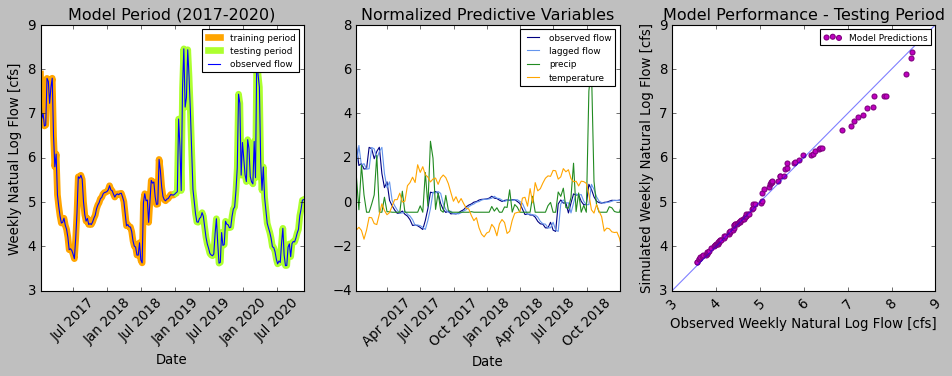

In [14]:
# Set plot style and sublot layout
plt.style.use('classic')
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()
fig.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.2)

# PLOT 1: Streamflow Data for Model Period
ax[0].plot(train['flow_log'], 'orange', label='training period', linewidth=6)
ax[0].plot(test['flow_log'], 'greenyellow', label='testing period', linewidth=6)
ax[0].plot(data['flow_log'], 'b', label='observed flow', linewidth=1)
ax[0].set(title="Model Period (2017-2020)",
          xlabel="Date", ylabel="Weekly Natual Log Flow [cfs]",
          xlim=['2017-01-07', '2020-11-21'])
ax[0].legend(fontsize=8)
plt.setp(ax[0].get_xticklabels(), rotation=45)

# PLOT 2: Normalized Predictive Variables
ax[1].plot(data['flow_log_nm'], 'navy', label='observed flow')
ax[1].plot(data['flow_tm1_nm'], 'cornflowerblue', label='lagged flow')
ax[1].plot(data['precip_nm'], 'forestgreen', label='precip')
ax[1].plot(data['airtemp_nm'], 'orange', label='temperature')
ax[1].set(title="Normalized Predictive Variables", xlabel="Date",
          xlim=['2017-01-07', '2018-12-29'])
ax[1].legend(fontsize=8)
plt.setp(ax[1].get_xticklabels(), rotation=45)

# PLOT 3: Model Performance
ax[2].scatter(np.sort(test['flow_log']), np.sort(q_pred_test), 
              color='m', edgecolor='purple', label='Model Predictions')
ax[2].plot([0,9], [0,9], 
              color='blue', alpha=0.5)
ax[2].set(title="Model Performance - Testing Period", xlabel="Observed Weekly Natural Log Flow [cfs]",
          ylabel="Simulated Weekly Natural Log Flow [cfs]", xlim = [3,9], ylim = [3,9])
ax[2].legend(fontsize=8)
plt.setp(ax[2].get_xticklabels(), rotation=45)

plt.show()

#### 1 Week and 2 Week Forecast
The 1 week and 2 week forecast are made using the linear regression model described above. Expected precipitation (in inches) and temperature (in fahrenheit) are entered manually, and then the initially defined function is called to calculate the 1 and 2 week predictions based on the lienar regression. The function normalizes the predicted inputs, uses the model coefficients and intercept to calculate predicted natural log streamflow, and the uses the exponential function to convert to the raw streamflow value. The function will print the predictions.

In [15]:
# Manually input expected precipitation and temperture for the next two weeks
precip_1wk = 0
precip_2wk = 0
temp_1wk = 45
temp_2wk = 50

# Call function to make prediction
model_predictions = model_2wk_predict(precip_1wk, precip_2wk, temp_1wk, temp_2wk)

Linear regression model  1  week forecast is  160.57  cfs
Linear regression model  2  week forecast is  166.92  cfs


#### Seasonal Forecast
My efforts have been focused on improving my near term forecast each week, so my seasonal forecast has not changed much over the course of the semester. The first few weeks of the semester revealed that 2020 was a low flow year compared to data since 1989. Attempting to statistically manipulate data over the entire period 1989-2019 to predict 2020 weekly average flows consistently resulted in overestimation of flow. I change strategies to use a similarly low flow year, 2019, as an indicator of what to expect in 2020. In the loop below, I assign the 2019 average flow over the week of interest as the forecast for 2020. December 2019 saw some large storm events and resulting increase in streamflow. I am predicting that we will not see similarly large storm events in early December this year, so the loop below places a cap of 200 cfs on any given weekly forecast.

In [16]:
flow_2019 = data["2019-08-31":"2019-12-14"]

lt_forecast = np.zeros(16)
for i in range(0, 16):
    if flow_2019['flow'].iloc[i] <= 200:
        lt_forecast[i] = flow_2019['flow'].iloc[i].round(0)
        print('lt_week', i+1, ' = ', flow_2019['flow'].iloc[i].round(0))
    else:
        lt_forecast[i] = 200
        print('lt_week', i+1, ' = 200')

lt_week 1  =  38.0
lt_week 2  =  74.0
lt_week 3  =  56.0
lt_week 4  =  57.0
lt_week 5  =  96.0
lt_week 6  =  90.0
lt_week 7  =  89.0
lt_week 8  =  83.0
lt_week 9  =  84.0
lt_week 10  =  107.0
lt_week 11  =  127.0
lt_week 12  =  133.0
lt_week 13  =  192.0
lt_week 14  = 200
lt_week 15  = 200
lt_week 16  = 200
